## IMPORTS

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from penaltyblog.matchflow import Flow, where_equals

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='statsbombpy')

In [2]:
MATCH_ID = 22912

print(f"Loading all events for match ID: {MATCH_ID}...")

flow = Flow.statsbomb.events(MATCH_ID)

# Collect the data into a list first
event_list = flow.collect()

df_events = pd.DataFrame(event_list)

print(f"\nSuccessfully loaded and converted {len(df_events):,} events for the match.")
print("Here are the first few events:")

display(df_events.head())

Loading all events for match ID: 22912...

Successfully loaded and converted 3,165 events for the match.
Here are the first few events:


,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,...,clearance,foul_won,interception,ball_recovery,counterpress,out,dribble,50_50,substitution,block
0,9ec3d009-c15b-4a8d-be80-57a07f40755a,1,1,00:00:00.000,0,0,"{'id': 35, 'name': 'Starting XI'}",1,"{'id': 38, 'name': 'Tottenham Hotspur'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,e8bdb5d1-8bcb-4a0d-bfd2-68c18c7f54d0,2,1,00:00:00.000,0,0,"{'id': 35, 'name': 'Starting XI'}",1,"{'id': 38, 'name': 'Tottenham Hotspur'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00b678a4-3767-4d0b-92e6-9cb4c959d94d,3,1,00:00:00.000,0,0,"{'id': 18, 'name': 'Half Start'}",1,"{'id': 38, 'name': 'Tottenham Hotspur'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,05840f64-0fb7-4f2d-885a-49790d6bd4df,4,1,00:00:00.000,0,0,"{'id': 18, 'name': 'Half Start'}",1,"{'id': 38, 'name': 'Tottenham Hotspur'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,b67ef6a9-e877-4dbe-bb03-edcc9d8c7711,5,1,00:00:00.208,0,0,"{'id': 30, 'name': 'Pass'}",2,"{'id': 24, 'name': 'Liverpool'}","{'id': 9, 'name': 'From Kick Off'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3: Basic Data Exploration

In [3]:
if 'df_events' in locals():
    # Print the shape of the DataFrame
    print(f"The DataFrame has {df_events.shape[0]} rows (events) and {df_events.shape[1]} columns (attributes).")

    # Let's see all available columns to find the right one
    print("\nAvailable columns:")
    print(df_events.columns.tolist())

    print("\nThe following event types were recorded in this match:")
    event_types = df_events['type'].apply(lambda x: x['name']).unique()
    display(event_types)
    
else:
    print("Event DataFrame not found. Please run the cell above first.")

The DataFrame has 3165 rows (events) and 37 columns (attributes).

Available columns:
['id', 'index', 'period', 'timestamp', 'minute', 'second', 'type', 'possession', 'possession_team', 'play_pattern', 'team', 'duration', 'tactics', 'match_id', 'related_events', 'player', 'position', 'location', 'pass', 'carry', 'ball_receipt', 'under_pressure', 'duel', 'foul_committed', 'shot', 'goalkeeper', 'off_camera', 'clearance', 'foul_won', 'interception', 'ball_recovery', 'counterpress', 'out', 'dribble', '50_50', 'substitution', 'block']

The following event types were recorded in this match:


array(['Starting XI', 'Half Start', 'Pass', 'Ball Receipt*', 'Carry',
       'Duel', 'Pressure', 'Foul Committed', 'Shot', 'Goal Keeper',
       'Clearance', 'Ball Recovery', 'Foul Won', 'Interception',
       'Miscontrol', 'Dispossessed', 'Dribbled Past', 'Dribble', '50/50',
       'Block', 'Shield', 'Injury Stoppage', 'Referee Ball-Drop',
       'Half End', 'Substitution', 'Tactical Shift', 'Offside'],
      dtype=object)

4: Count Events by Player 

In [4]:
if 'flow' in locals():
    print("Counting the total number of on-ball events for each player...")

    events_by_player = (
        flow.group_by("player.name")
        .summary({"total_events": ("count", "id")})
        
        .sort_by("total_events", ascending=False)
        .rename(**{"player.name": "player"})
        .collect()
    )

    df_player_events = pd.DataFrame(events_by_player)

    print("\n--- Most Active Players (by Total Events) ---")
    display(df_player_events.head(10))

else:
    print("Matchflow object 'flow' not found. Please load the match data first.")

Counting the total number of on-ball events for each player...

--- Most Active Players (by Total Events) ---


,total_events,player
0,229,Jan Vertonghen
1,213,Toby Alderweireld
2,181,Kieran Trippier
3,165,Hugo Lloris
4,156,Christian Dannemann Eriksen
5,153,Bamidele Alli
6,153,Danny Rose
7,147,Harry Winks
8,142,Heung-Min Son
9,140,Sadio Mané


5: Install mplsoccer and Prepare Pass Data

In [5]:
from penaltyblog.matchflow import get_field

LIVERPOOL_TEAM_NAME = "Liverpool"

print(f"Filtering for all completed passes by {LIVERPOOL_TEAM_NAME}...")

liverpool_passes = (
    flow.filter(where_equals("team.name", LIVERPOOL_TEAM_NAME))
    .filter(where_equals("type.name", "Pass"))
    .filter(lambda r: get_field(r, "pass.outcome.name") is None)
    
    # --- FIX: Use .split_array() to correctly extract coordinates ---
    .split_array("location", ["start_x", "start_y"])
    .split_array("pass.end_location", ["end_x", "end_y"])
    
    .select(
        "player.name", 
        "pass.recipient.name", 
        "start_x", 
        "start_y", 
        "end_x", 
        "end_y"
    )
    .collect()
)

df_liverpool_passes = pd.DataFrame(liverpool_passes)


if not df_liverpool_passes.empty:
    print(f"\nFound and processed {len(df_liverpool_passes)} completed passes.")
    display(df_liverpool_passes.head())
else:
    print("\nNo completed passes found for Liverpool.")

Filtering for all completed passes by Liverpool...

Found and processed 202 completed passes.


,player,pass,start_x,start_y,end_x,end_y
0,{'name': 'Jordan Brian Henderson'},{'recipient': {'name': 'Joël Andre Job Matip'}},61.0,40.1,34.0,43.8
1,{'name': 'Virgil van Dijk'},{'recipient': {'name': 'Georginio Wijnaldum'}},59.5,19.6,65.4,19.2
2,{'name': 'Georginio Wijnaldum'},{'recipient': {'name': 'Jordan Brian Henderson'}},64.7,18.4,64.9,23.8
3,{'name': 'Jordan Brian Henderson'},{'recipient': {'name': 'Sadio Mané'}},64.3,24.3,99.2,24.5
4,{'name': 'Andrew Robertson'},{'recipient': {'name': 'Sadio Mané'}},43.7,0.1,53.6,8.5


6: Calculate Average Player Positions

In [6]:
if 'flow' in locals():
    print(f"Calculating the average on-pitch location for each {LIVERPOOL_TEAM_NAME} player...")

    # We filter for Liverpool events, split the location array, group by player, and find the mean location
    player_locations = (
        flow.filter(where_equals("team.name", LIVERPOOL_TEAM_NAME))
        .filter(lambda r: get_field(r, "location") is not None) 
        .split_array("location", ["x", "y"])
        .group_by("player.name")
        .summary({"avg_x": ("mean", "x"), "avg_y": ("mean", "y")})
        .rename(**{"player.name": "player"})
        .collect()
    )

    # Convert to a DataFrame
    df_player_locations = pd.DataFrame(player_locations)

    print("\n--- Average Player Positions ---")
    display(df_player_locations)

else:
    print("Matchflow object 'flow' not found. Please load the match data first.")

Calculating the average on-pitch location for each Liverpool player...

--- Average Player Positions ---


,avg_x,avg_y,player
0,64.910744,54.105785,Jordan Brian Henderson
1,31.391209,54.101099,Joël Andre Job Matip
2,77.589209,22.246763,Sadio Mané
3,52.390323,41.867742,Fábio Henrique Tavares
4,77.695652,37.211957,Roberto Firmino Barbosa de Oliveira
5,35.614130,31.170652,Virgil van Dijk
6,64.644615,27.747692,Georginio Wijnaldum
7,88.010870,54.762319,Mohamed Salah
8,50.833571,11.250714,Andrew Robertson
9,53.671795,63.534188,Trent Alexander-Arnold


7: Plot the Team Pass Map

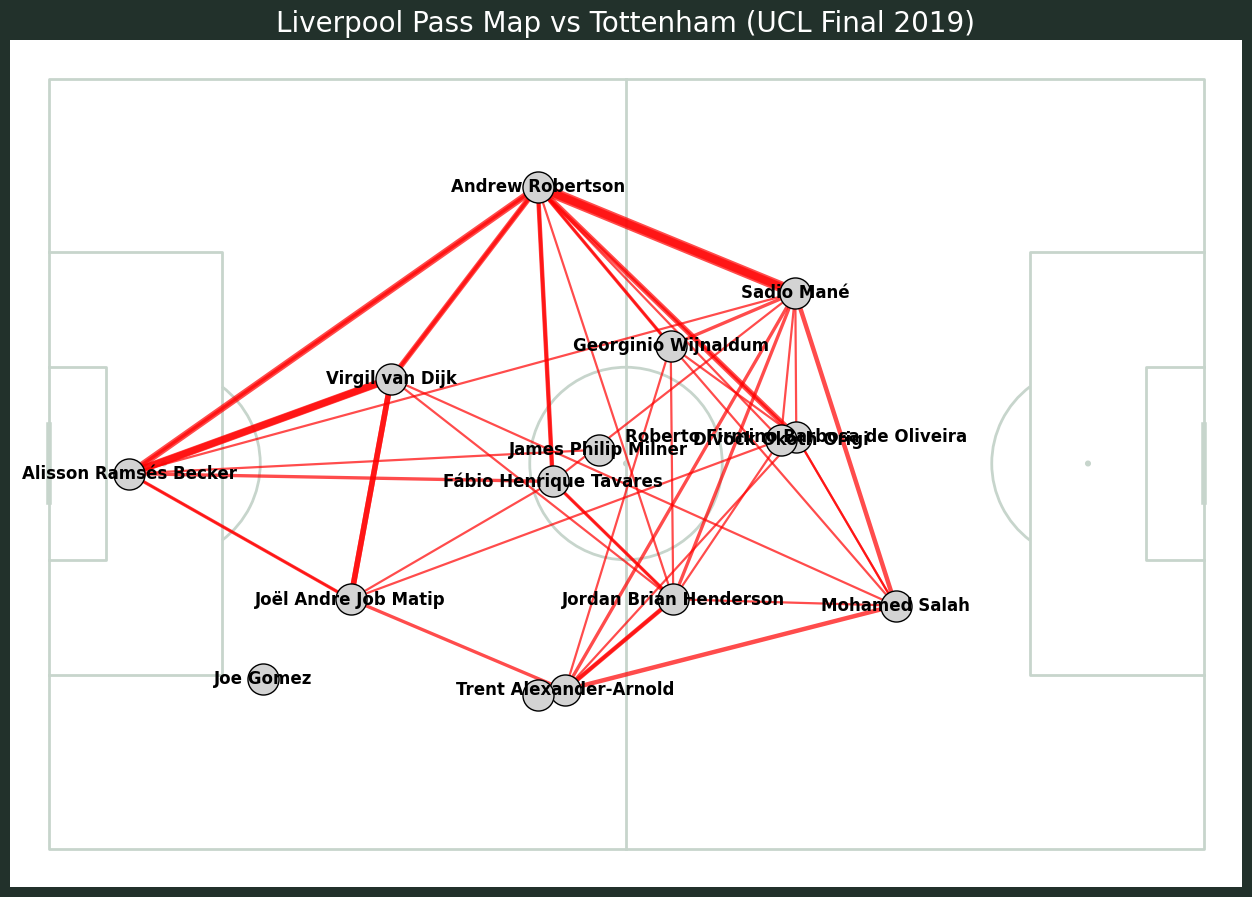

In [7]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Prepare the data (No changes needed) ---
df_liverpool_passes['passer'] = df_liverpool_passes['player'].apply(
    lambda x: x.get('name') if isinstance(x, dict) else None
)
df_liverpool_passes['recipient'] = df_liverpool_passes['pass'].apply(
    lambda x: x.get('recipient', {}).get('name') if isinstance(x, dict) else None
)
df_liverpool_passes.dropna(subset=['passer', 'recipient'], inplace=True)
df_pass_counts = df_liverpool_passes.groupby(['passer', 'recipient']).size().reset_index(name='pass_count')
df_pass_counts = pd.merge(df_pass_counts, df_player_locations, left_on='passer', right_on='player', how='inner')
df_pass_counts = pd.merge(df_pass_counts, df_player_locations, left_on='recipient', right_on='player', how='inner', suffixes=('_start', '_end'))


# --- 2. Create the plot ---
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
fig.set_facecolor("#22312b")

MIN_PASS_COUNT = 2 
for _, row in df_pass_counts[df_pass_counts['pass_count'] >= MIN_PASS_COUNT].iterrows():
    pitch.lines(
        xstart=row['avg_x_start'], ystart=row['avg_y_start'],
        xend=row['avg_x_end'], yend=row['avg_y_end'],
        lw=row['pass_count'] * 0.8, color='#FF0000', zorder=2, ax=ax, alpha=0.7
    )

pitch.scatter(df_player_locations.avg_x, df_player_locations.avg_y, s=500, color='#d3d3d3', edgecolors='black', zorder=3, ax=ax)
for _, row in df_player_locations.iterrows():
    pitch.annotate(row['player'], xy=(row['avg_x'], row['avg_y']), c='black', va='center', ha='center', size=12, ax=ax, zorder=4, weight='bold')

ax.set_title(f"{LIVERPOOL_TEAM_NAME} Pass Map vs Tottenham (UCL Final 2019)", color="white", size=20)
plt.show()

8: Create an Advanced Shot Map

Filtering for all shots taken by Liverpool...

Columns available in shots DataFrame: ['location', 'shot', 'player']

Found 14 total shots.


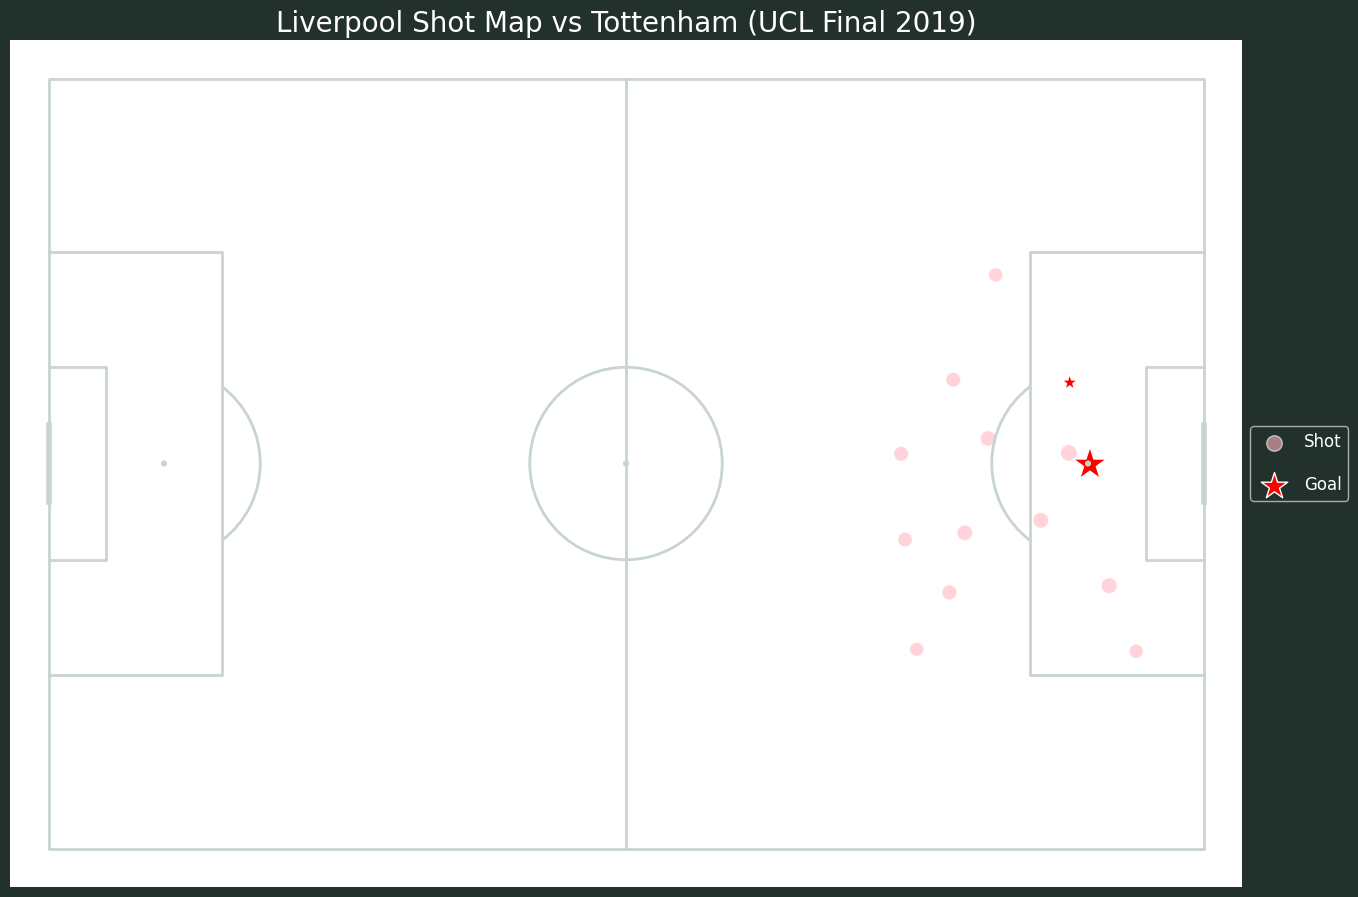

In [9]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Filter for all of Liverpool's shots ---
print("Filtering for all shots taken by Liverpool...")
liverpool_shots_raw = (
    flow.filter(where_equals("team.name", "Liverpool"))
    .filter(where_equals("type.name", "Shot"))
    .select(
        "location",
        "shot",
        "player"
    )
    .collect()
)
df_shots = pd.DataFrame(liverpool_shots_raw)

print("\nColumns available in shots DataFrame:", df_shots.columns.tolist())


# --- 2. Extract nested data and separate goals from other shots ---
df_shots['x'] = df_shots['location'].apply(lambda loc: loc[0])
df_shots['y'] = df_shots['location'].apply(lambda loc: loc[1])
df_shots['xg'] = df_shots['shot'].apply(lambda s: s.get('statsbomb_xg'))
df_shots['outcome'] = df_shots['shot'].apply(lambda s: s.get('outcome', {}).get('name'))
df_shots['player_name'] = df_shots['player'].apply(lambda p: p.get('name'))

print(f"\nFound {len(df_shots)} total shots.")

df_goals = df_shots[df_shots['outcome'] == 'Goal'].copy()
df_other_shots = df_shots[df_shots['outcome'] != 'Goal'].copy()


# --- 3. Create the plot ---
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
fig.set_facecolor("#22312b")
ax.set_title(f"Liverpool Shot Map vs Tottenham (UCL Final 2019)", color="white", size=20)

# Plot non-goal shots
pitch.scatter(
    df_other_shots.x, df_other_shots.y,
    s=(df_other_shots['xg'] * 700) + 100,
    ax=ax, color='#FFB6C1', edgecolors='white', alpha=0.6, label='Shot'
)

# Plot goals
if not df_goals.empty:
    pitch.scatter(
        df_goals.x, df_goals.y,
        s=(df_goals['xg'] * 700) + 100,
        ax=ax, color='#FF0000', edgecolors='white', marker='*', linewidth=1, label='Goal'
    )

legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), labelspacing=1.5, fontsize=12, facecolor='#22312b')
for text in legend.get_texts():
    text.set_color('white')

plt.show()

9: Create a Player Heatmap

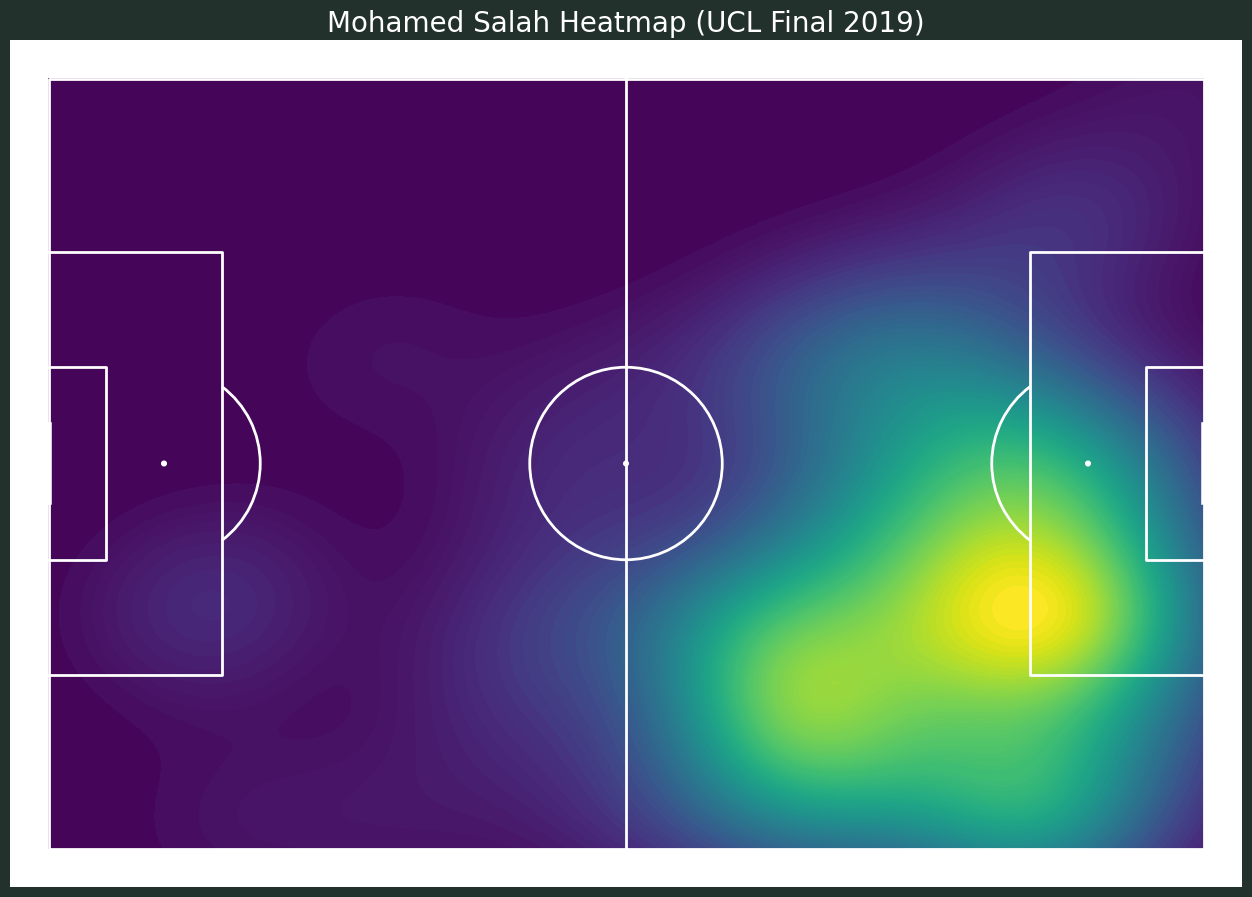

In [17]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Filter for all of Mohamed Salah's events ---
PLAYER_NAME = "Mohamed Salah"
TEAM_NAME = "Liverpool"

player_events = (
    flow.filter(where_equals("team.name", TEAM_NAME))
    .filter(where_equals("player.name", PLAYER_NAME))
    .filter(lambda r: get_field(r, "location") is not None)
    .split_array("location", ["x", "y"])
    .select("x", "y")
    .collect()
)
df_player_events = pd.DataFrame(player_events)

# --- 2. Create the plot ---
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, line_color='white')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
fig.set_facecolor("#22312b")
ax.set_title(f"{PLAYER_NAME} Heatmap (UCL Final 2019)", color="white", size=20)

if not df_player_events.empty:
    pitch.kdeplot(
        df_player_events.x,
        df_player_events.y,
        ax=ax,
        fill=True,
        levels=100,
        shade_lowest=True,
        cmap='viridis'
    )

plt.show()

### Step 10: Feature Engineering

In [20]:
# --- V3 - Step 10 (Corrected): Feature Engineering ---

print("Calculating key team-level features for the match...")

# --- 1. Calculate Shots and xG for each team ---
shot_stats = (
    flow.filter(where_equals("type.name", "Shot"))
    .group_by("team.name")
    # --- FIX: Pass the aggregations as a single dictionary ---
    .summary({
        "total_shots": ("count", "id"),
        "total_xg": ("sum", "shot.statsbomb_xg")
    })
    .rename(**{"team.name": "team"})
    .collect()
)
df_shot_stats = pd.DataFrame(shot_stats)


# --- 2. Calculate Possession for each team ---
team_possession = (
    flow.filter(lambda r: get_field(r, "duration") is not None)
    .group_by("team.name")
    # --- FIX: Pass the aggregations as a single dictionary ---
    .summary({
        "total_duration_of_possession": ("sum", "duration")
    })
    .rename(**{"team.name": "team"})
    .collect()
)
df_possession = pd.DataFrame(team_possession)

total_match_duration = df_possession['total_duration_of_possession'].sum()
df_possession['possession_pct'] = (df_possession['total_duration_of_possession'] / total_match_duration) * 100


# --- 3. Combine into a final summary table ---
df_summary = pd.merge(df_shot_stats, df_possession, on='team')

print("\n--- Match Summary Statistics ---")
display(df_summary[['team', 'total_shots', 'total_xg', 'possession_pct']])

Calculating key team-level features for the match...

--- Match Summary Statistics ---


,team,total_shots,total_xg,possession_pct
0,Liverpool,14,1.203148,40.204198
1,Tottenham Hotspur,16,0.924264,59.795802


### Step 11: Train the model

In [25]:
import pandas as pd
from tqdm.auto import tqdm
from penaltyblog.matchflow import Flow, where_equals, get_field

#2015-2016 Season
COMPETITION_ID = 2
SEASON_ID = 27

# --- 1. Get the list of all matches for the season ---
print(f"Fetching all matches for Premier League season ID {SEASON_ID}...")
matches = Flow.statsbomb.matches(competition_id=COMPETITION_ID, season_id=SEASON_ID).collect()
print(f"Found {len(matches)} matches to process.")

# --- 2. Loop through each match and engineer features ---
training_data = []
for match in tqdm(matches, desc="Processing Matches"):
    try:
        match_id = match['match_id']
        home_team = match['home_team']['home_team_name']
        away_team = match['away_team']['away_team_name']
        home_score = match['home_score']
        away_score = match['away_score']
        
        flow = Flow.statsbomb.events(match_id).cache()

        # a) Shot Stats
        shot_stats = (
            flow.filter(where_equals("type.name", "Shot"))
            .group_by("team.name")
            .summary({"total_shots": ("count", "id"), "total_xg": ("sum", "shot.statsbomb_xg")})
            .collect()
        )
        df_shot_stats = pd.DataFrame(shot_stats)

        # b) Possession Stats
        team_possession = (
            flow.filter(lambda r: get_field(r, "duration") is not None)
            .group_by("team.name")
            .summary({"possession_duration": ("sum", "duration")})
            .collect()
        )
        df_possession = pd.DataFrame(team_possession)
        total_duration = df_possession['possession_duration'].sum()
        df_possession['possession_pct'] = (df_possession['possession_duration'] / total_duration) * 100 if total_duration > 0 else 0

        # c) Organize features
        home_shots = df_shot_stats[df_shot_stats['team.name'] == home_team].iloc[0] if not df_shot_stats[df_shot_stats['team.name'] == home_team].empty else pd.Series({'total_shots': 0, 'total_xg': 0})
        away_shots = df_shot_stats[df_shot_stats['team.name'] == away_team].iloc[0] if not df_shot_stats[df_shot_stats['team.name'] == away_team].empty else pd.Series({'total_shots': 0, 'total_xg': 0})
        home_poss = df_possession[df_possession['team.name'] == home_team].iloc[0] if not df_possession[df_possession['team.name'] == home_team].empty else pd.Series({'possession_pct': 0})
        away_poss = df_possession[df_possession['team.name'] == away_team].iloc[0] if not df_possession[df_possession['team.name'] == away_team].empty else pd.Series({'possession_pct': 0})

        # d) Create the row
        row = {
            'match_id': match_id, 'home_team': home_team, 'away_team': away_team,
            'home_score': home_score, 'away_score': away_score,
            'home_shots': home_shots['total_shots'], 'away_shots': away_shots['total_shots'],
            'home_xg': home_shots['total_xg'], 'away_xg': away_shots['total_xg'],
            'home_possession': home_poss['possession_pct'], 'away_possession': away_poss['possession_pct'],
        }
        training_data.append(row)

    except Exception as e:
        print(f"\nSkipping match_id {match.get('match_id', 'N/A')} due to an error: {e}")
        continue

# --- 3. Create the final DataFrame ---
df_train = pd.DataFrame(training_data)

print(f"\nFeature engineering complete. Created a dataset with {df_train.shape[0]} matches and {df_train.shape[1]} columns.")
display(df_train.head())

Fetching all matches for Premier League season ID 27...
Found 380 matches to process.


Processing Matches:   0%|          | 0/380 [00:00<?, ?it/s]


Feature engineering complete. Created a dataset with 380 matches and 11 columns.


,match_id,home_team,away_team,home_score,away_score,home_shots,away_shots,home_xg,away_xg,home_possession,away_possession
0,3754058,Leicester City,AFC Bournemouth,0,0,17,10,2.822871,0.936503,52.032612,47.967388
1,3754245,West Bromwich Albion,Sunderland,1,0,9,10,1.476454,0.670351,53.976257,46.023743
2,3754136,Newcastle United,Aston Villa,1,1,8,10,1.085261,0.380228,47.854615,52.145385
3,3754037,Everton,AFC Bournemouth,2,1,11,16,0.890678,1.429667,55.769784,44.230216
4,3754039,Crystal Palace,Watford,1,2,15,11,1.142375,1.703768,52.303056,47.696944


11.1: Prepare Data for Machine Learning

In [27]:
from sklearn.model_selection import train_test_split

# 1. Define the Target Variable (y)
def get_result(row):
    if row['home_score'] > row['away_score']:
        return 1  # Home Win
    elif row['home_score'] < row['away_score']:
        return 2  # Away Win
    else:
        return 0  # Draw
df_train['result'] = df_train.apply(get_result, axis=1)

# 2. Define the Features (X)
features = [
    'home_shots',
    'away_shots',
    'home_xg',
    'away_xg',
    'home_possession',
    'away_possession'
]

X = df_train[features]
y = df_train['result']

# 3. Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y # Stratify ensures consistent class distribution
)

print("Data successfully prepared and split for training and testing.")
print(f"Training set size: {len(X_train)} matches")
print(f"Testing set size: {len(X_test)} matches")

Data successfully prepared and split for training and testing.
Training set size: 304 matches
Testing set size: 76 matches


11.2: Train and Evaluate the XGBoost Model

In [29]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# --- 1. Train the XGBoost Model ---
print("\nTraining the XGBoost model...")

# Instantiate the model with standard parameters
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax', 
    num_class=3,
    seed=42
)

# Train the model on the training data
xgb_model.fit(X_train, y_train)
print("Model training complete.")


# --- 2. Evaluate the Model on the Test Set ---
print("\nEvaluating model performance on the unseen test set...")

# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.2%}")

# Display a detailed classification report
print("\nClassification Report:")
target_names = ['Draw', 'Home Win', 'Away Win']
print(classification_report(y_test, y_pred, target_names=target_names))


Training the XGBoost model...
Model training complete.

Evaluating model performance on the unseen test set...

Model Accuracy: 53.95%

Classification Report:
              precision    recall  f1-score   support

        Draw       0.38      0.27      0.32        22
    Home Win       0.68      0.81      0.74        31
    Away Win       0.43      0.43      0.43        23

    accuracy                           0.54        76
   macro avg       0.50      0.50      0.50        76
weighted avg       0.52      0.54      0.52        76



11.3: Hyperparams Tuning

In [31]:
from sklearn.model_selection import GridSearchCV

print("Starting hyperparameter tuning with Grid Search...")

# 1. Define the grid of parameters to test
param_grid = {
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.1, 0.05]
}

# 2. Set up the Grid Search
# cv=3 means it will use 3-fold cross-validation for each combination.
# n_jobs=-1 uses all available CPU cores to speed up the process.
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1 
)

# 3. Run the Grid Search on the training data
grid_search.fit(X_train, y_train)

# 4. Display the best parameters found
print("\nHyperparameter tuning complete.")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.2%}")

# We can now create a new, optimized model using these best parameters
optimized_model = grid_search.best_estimator_

Starting hyperparameter tuning with Grid Search...
Fitting 3 folds for each of 18 candidates, totalling 54 fits

Hyperparameter tuning complete.
Best parameters found: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150}
Best cross-validation accuracy: 55.58%


In [32]:
from sklearn.metrics import accuracy_score, classification_report

print("--- Evaluating the final, tuned model on the unseen test set ---")

# The 'optimized_model' was created in the previous cell
# It is the best model found by the Grid Search.

# Make predictions on the test data using the new model
y_pred_optimized = optimized_model.predict(X_test)

# Calculate the new accuracy
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)

# --- Final Comparison ---

print(f"\nOriginal Model Accuracy: {accuracy:.2%}") # 'accuracy' is from our first evaluation
print(f"Tuned Model Accuracy:    {accuracy_optimized:.2%}")

improvement = accuracy_optimized - accuracy
print(f"\nImprovement: {improvement:+.2%}")


# Display a detailed classification report for the final model
print("\nClassification Report for Tuned Model:")
target_names = ['Draw', 'Home Win', 'Away Win']
print(classification_report(y_test, y_pred_optimized, target_names=target_names))

--- Evaluating the final, tuned model on the unseen test set ---

Original Model Accuracy: 53.95%
Tuned Model Accuracy:    48.68%

Improvement: -5.26%

Classification Report for Tuned Model:
              precision    recall  f1-score   support

        Draw       0.33      0.23      0.27        22
    Home Win       0.59      0.74      0.66        31
    Away Win       0.41      0.39      0.40        23

    accuracy                           0.49        76
   macro avg       0.44      0.45      0.44        76
weighted avg       0.46      0.49      0.47        76

